In [43]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

In [9]:
folder_generated = os.path.exists('MRI_Images')

if not folder_generated:
    os.makedirs('./MRI_Images')


if os.path.exists('./MRI_Images') and not os.listdir('./MRI_Images'):
    for folder_name in ("yes", "no"):
        print(folder_name)
        os.path.join('./MRI_Images', f'./BrainTumorsData/brain_tumor_dataset/{folder_name}')

yes
no


In [24]:
image_dir = './BrainTumorsData/brain_tumor_dataset/'

image_size = (256, 256)
batch_size = 128
class_names = ['yes', 'no']
os.listdir(image_dir)

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size)



Found 253 files belonging to 3 classes.
Using 203 files for training.
Using 50 files for validation.


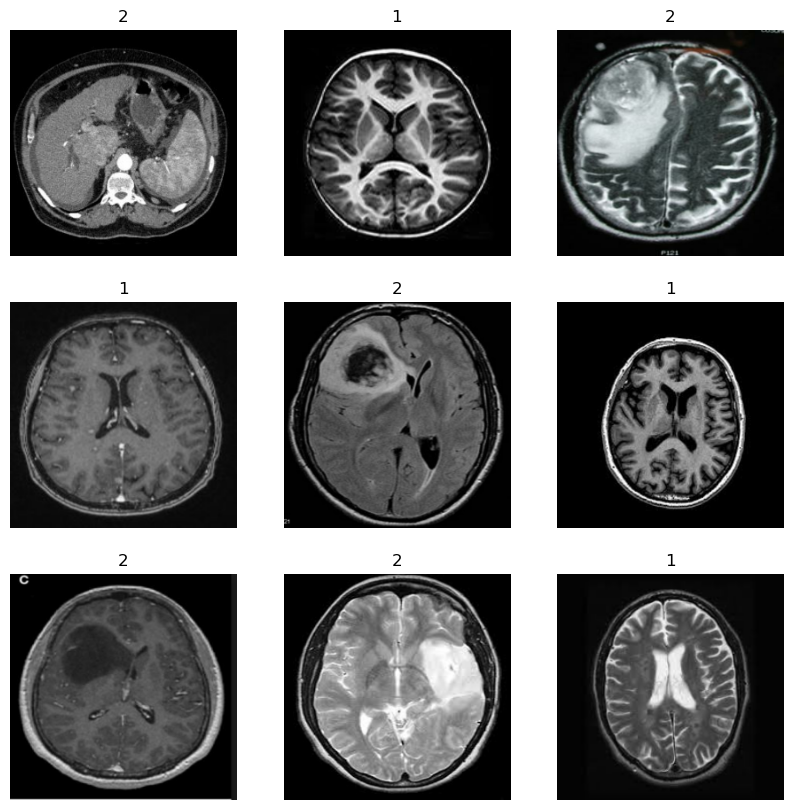

In [32]:
# Display Images with their Label
# 1 = No tumor, 2 = tumor

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

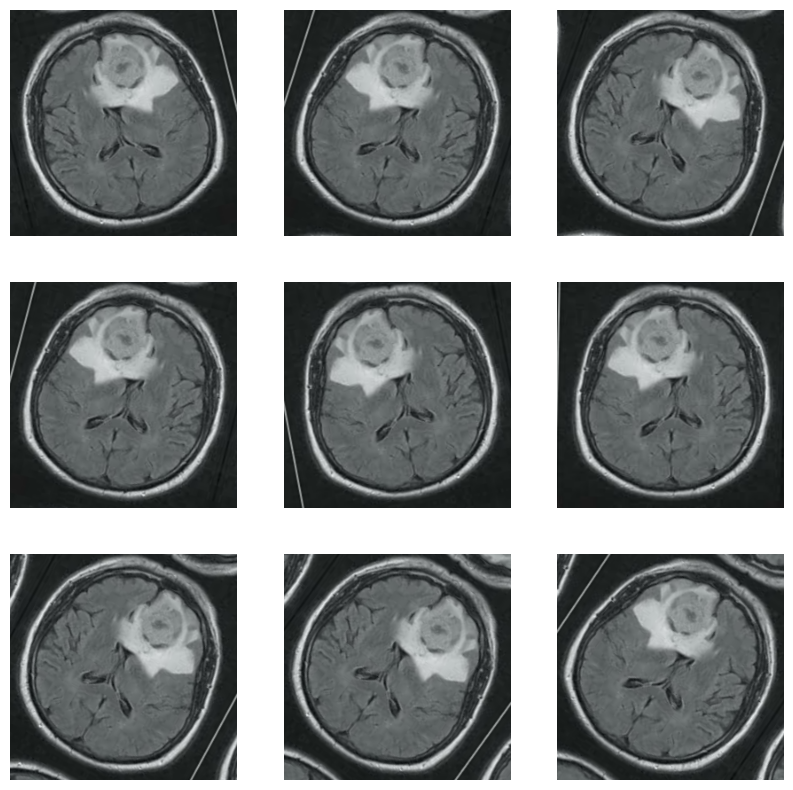

In [37]:
# Increasing the amount of data by rotating images in order to generate more for the model to be trained by

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ])

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [39]:
# Create augmented training data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
augmented_train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [40]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [45]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [46]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
2/2 [==============================] - 173s 42s/step - loss: 0.1056 - accuracy: 0.2315 - val_loss: 0.6429 - val_accuracy: 0.4000
Epoch 2/25
2/2 [==============================] - 149s 39s/step - loss: -1.5876 - accuracy: 0.3005 - val_loss: 0.5885 - val_accuracy: 0.4000
Epoch 3/25
2/2 [==============================] - 134s 40s/step - loss: -2.6384 - accuracy: 0.3744 - val_loss: 0.5244 - val_accuracy: 0.4000
Epoch 4/25
2/2 [==============================] - 137s 43s/step - loss: -3.5935 - accuracy: 0.3596 - val_loss: 0.4501 - val_accuracy: 0.4000
Epoch 5/25
2/2 [==============================] - 123s 42s/step - loss: -4.4906 - accuracy: 0.3744 - val_loss: 0.3700 - val_accuracy: 0.4000
Epoch 6/25
2/2 [==============================] - 136s 37s/step - loss: -5.3211 - accuracy: 0.3645 - val_loss: 0.2861 - val_accuracy: 0.4000
Epoch 7/25
2/2 [==============================] - 157s 41s/step - loss: -6.1266 - accuracy: 0.3793 - val_loss: 0.1933 - val_accuracy: 0.4000
Epoch 8/25
2/2

In [56]:
img = keras.preprocessing.image.load_img("./BrainTumorsData/no/2 no.jpeg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
score = float(predictions[0])
score
# print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 119ms/step


0.8965288996696472

In [55]:
img = keras.preprocessing.image.load_img("./BrainTumorsData/yes/Y101.jpg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
score = float(predictions[0])
score
# print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 135ms/step


0.9004784822463989